In [3]:
#!/usr/bin/env python3
# -*- coding: utf-8 -*-
"""
    Created on Wed Mar 20 2024
    
    @author: Yaning
"""

from tqdm import tqdm

import numpy as np
import torch
import pandas as pd

import pyro
import pyro.distributions as dist

# np.random.seed(123)
# torch.manual_seed(123)

/tmp/ipykernel_1102494/343571747.py:13: DeprecationWarning: 
Pyarrow will become a required dependency of pandas in the next major release of pandas (pandas 3.0),
(to allow more performant data types, such as the Arrow string type, and better interoperability with other libraries)
but was not found to be installed on your system.
If this would cause problems for you,
please provide us feedback at https://github.com/pandas-dev/pandas/issues/54466
        
  import pandas as pd


In [7]:
# np.random.seed(123)
# torch.manual_seed(123)

# beta_variance = lambda alpha, beta: alpha*beta / ((alpha+beta)**2 * (alpha + beta + 1))
# gamma_variance = lambda conc, rate: conc/(rate**2)

# device = torch.device("cpu")

# torch.set_default_tensor_type(torch.DoubleTensor)


def model(num_params, num_agents):
    # define hyper priors over model parameters
    # prior over sigma of a Gaussian is a Gamma distribution
    a = pyro.param('a', torch.ones(num_params), constraint=dist.constraints.positive)
    lam = pyro.param('lam', torch.ones(num_params), constraint=dist.constraints.positive)
    tau = pyro.sample('tau', dist.Gamma(a, a/lam).to_event(1)) # mean = a / (a/lam) = lam
    print(a)
    sig = pyro.deterministic('sig', 1/torch.sqrt(tau)) # Gauss sigma

    # each model parameter has a hyperprior defining group level mean
    # in the form of a Normal distribution
    m = pyro.param('m', torch.zeros(num_params))
    s = pyro.param('s', torch.ones(num_params), constraint=dist.constraints.positive)
    mu = pyro.sample('mu', dist.Normal(m, s*sig).to_event(1)) # Gauss mu, wieso s*sig?

    # in order to implement groups, where each subject is independent of the others, pyro uses so-called plates.
    # you embed what should be done for each subject into the "with pyro.plate" context
    # the plate vectorizes subjects and adds an additional dimension onto all arrays/tensors
    # i.e. p1 below will have the length num_agents
    with pyro.plate('ag_idx', num_agents):
        # draw parameters from Normal and transform (for numeric trick reasons)
        base_dist = dist.Normal(0., 1.).expand_by([num_params]).to_event(1)
        # Transform via the pointwise affine mapping y = loc + scale*x (-> Neal's funnel)
        transform = dist.transforms.AffineTransform(mu, sig) 
        locs = pyro.sample('locs', dist.TransformedDistribution(base_dist, [transform]))
    
    with pyro.plate('test', 3):
        print("this line runs")
        print(locs[0])
    return locs
            

In [8]:
model(5,3)

tensor([1., 1., 1., 1., 1.], grad_fn=<AddBackward0>)
this line runs
tensor([-2.9794, -0.2724,  0.8072,  1.2617, -1.7985],
       grad_fn=<SelectBackward0>)


tensor([[-2.9794, -0.2724,  0.8072,  1.2617, -1.7985],
        [-3.9327, -0.6592,  1.2860,  1.0928, -2.2216],
        [-3.4891, -1.4599, -0.1738,  1.3864, -1.6744]], grad_fn=<AddBackward0>)

In [10]:
def guide(num_params, num_agents):
    # biject_to(constraint) looks up a bijective Transform from constraints.real 
    # to the given constraint. The returned transform is guaranteed to have 
    # .bijective = True and should implement .log_abs_det_jacobian().
    trns = torch.distributions.biject_to(dist.constraints.positive)
    print(trns)
    # define mean vector and covariance matrix of multivariate normal
    m_hyp = pyro.param('m_hyp', torch.zeros(2*num_params))
    st_hyp = pyro.param('scale_tril_hyp',
                    torch.eye(2*num_params),
                    constraint=dist.constraints.lower_cholesky)

    # set hyperprior to be multivariate normal
    # scale_tril (Tensor) – lower-triangular factor of covariance, with positive-valued diagonal
    hyp = pyro.sample('hyp',
                    dist.MultivariateNormal(m_hyp, scale_tril=st_hyp),
                    infer={'is_auxiliary': True})

    # mu & tau unconstrained
    unc_mu = hyp[..., :num_params]
    unc_tau = hyp[..., num_params:]

    # constrained tau, shape num_params, or num_particles, 1, num_params
    c_tau = trns(unc_tau)

    # ld = log_density
    # log_abs_det_jacobian(x, y) computes derivative |dy/dx|
    ld_tau = -trns.inv.log_abs_det_jacobian(c_tau, unc_tau)
    
    # sum_rightmost(x, dim)
    # sum out ``dim`` many rightmost dimensions of a given tensor.
    # ld_tau.shape is num_params, or num_particles, 1, num_params before sum_rightmost
    ld_tau = dist.util.sum_rightmost(ld_tau, ld_tau.dim() - c_tau.dim() + 1)

    # some numerics tricks
    mu = pyro.sample("mu", dist.Delta(unc_mu, event_dim=1))
    # c_tau shape: num_params, or num_particles, 1, num_params
    # ld_tau shape: [] or num_particles, 1,
    tau = pyro.sample("tau", dist.Delta(c_tau, log_density=ld_tau, event_dim=1))

    m_locs = pyro.param('m_locs', torch.zeros(num_agents, num_params))
    st_locs = pyro.param('scale_tril_locs',
                    torch.eye(num_params).repeat(num_agents, 1, 1),
                    constraint=dist.constraints.lower_cholesky)
    
    with pyro.plate('ag_idx', num_agents):
        locs = pyro.sample("locs", dist.MultivariateNormal(m_locs, scale_tril=st_locs))

    return {'tau': tau, 'mu': mu, 'locs': locs, 'm_locs': m_locs, 'st_locs': st_locs}

ComposeTransform(
    ExpTransform(),
    AffineTransform()
)


/home/yaning/Documents/python_env/pyro/lib/python3.11/site-packages/torch/random.py:157: UserWarning: CUDA reports that you have 2 available devices, and you have used fork_rng without explicitly specifying which devices are being used. For safety, we initialize *every* CUDA device by default, which can be quite slow if you have a lot of CUDAs. If you know that you are only making use of a few CUDA devices, set the environment variable CUDA_VISIBLE_DEVICES or the 'devices' keyword argument of fork_rng with the set of devices you are actually using. For example, if you are using CPU only, set device.upper()_VISIBLE_DEVICES= or devices=[]; if you are using device 0 only, set CUDA_VISIBLE_DEVICES=0 or devices=[0].  To initialize all devices and suppress this warning, set the 'devices' keyword argument to `range(torch.cuda.device_count())`.
  warnings.warn(message)


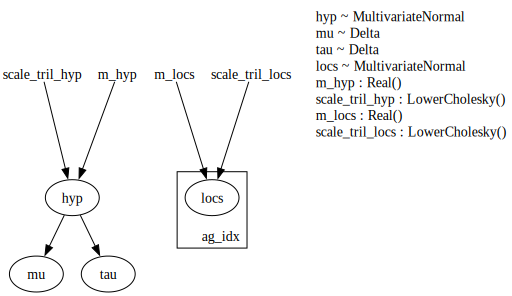

In [11]:
pyro.render_model(guide, model_args=(5,3), render_params=True, render_distributions=True)